# Model-Predictive Path Integral Control Example

In [ ]:
%load_ext autoreload
%autoreload 2

## Imports and Parameters

In [469]:
import time
from utils import * # imports integrators and other useful things
from system import * # imports system dynamics and objective
from MPPI import MPPI # imports controller
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

###################
# System parameters
# x0 = np.array([0,0])
# x0 = np.array([0,0,np.pi/3.0])
x0 = np.array([0,0,0,0])
del_t = 0.2 # 0.05 was good for diff, 0.2 for others
w_sz = 15
ov = 1
# dyn = lambda x, u: single_int(x,u) 
dyn = lambda x, u: double_int(x,u) 
# dyn = lambda x, u: diff_drive(x,u) 

######################
# Objective parameters
R = 0.1*np.diag([1.0,1.0])
# xd = np.array([5,2])
# Q = np.diag([1,1])
# xd = np.array([5.,2.,0.])
# Q = np.diag([1,1,.01])
# R = None
u0 = np.array([0.1, 0.1])
mean1 = np.array([-1.5,-1.5])
mean2 = np.array([1.5, 1.5])
cov1 = 1.*np.diag([1, 1])
cov2 = 1.*np.diag([1, 1])
w1 = 20.0 # weight given to tracking objective, 20 worked for single int, 1 worked for diff
w2 = -5.0 # weight given to rattling objective, -5 worked for single int, -70 worked for diff 
# obj = lambda x, u: quadratic_objective(x,u,xd,Q,R)
# obj = lambda x, u: quadratic_rattling_objective(x, u, del_t, w1, w2, None, w_sz, ov, xd, Q, R)
obj = lambda x, u: bimodal_rattling_objective(x[:2,:], u, mean1, cov1, mean2, cov2, del_t, w1, w2, w_sz, ov, R)
# obj = lambda x, u: bimodal_rattling_objective(x, u, mean1, cov1, mean2, cov2, del_t, w1, w2, w_sz, ov, R)

#######################
# Controller parameters
noise_mean = np.array([0.0, 0.0])
noise_var = 5.0*np.diag([1.0, 1.0]) # 5 worked for diff, 2 for others
samp_num = 40 # 100 was good for diff
predictive_horizon = 30 # 100 was good for diff
simulation_length = 400 # 1000 was good for diff
Temp = 1.0

## Initialize Controller

In [460]:
controller = MPPI(dyn, obj, x0, u0, K=samp_num, N=predictive_horizon, dt=del_t, lamb=Temp, noise_mu=noise_mean, noise_sigma=noise_var)

## Main Loop

In [461]:
tic = time.time()
xlist = []
ulist = []
costlist = []
for i in range(simulation_length):
    u_star = controller.step(x0)[:,0]
#     u_star = np.random.multivariate_normal(noise_mean, noise_var)
    x = integrate(dyn,x0,u_star,del_t)
    x0 = np.copy(x)
    xlist.append(x0)
    ulist.append(u_star)
    costlist.append(np.mean(controller.cost_total))
    if (i+1) % int(simulation_length/4.0) == 0:
        print(str(int(100.0*((float(i+1)/float(simulation_length)))))+"% complete. Time elapsed: "+str(np.round(time.time()-tic,2))+"s.")
xtraj = np.array(xlist).T
utraj = np.array(ulist).T

25% complete. Time elapsed: 13.77s.
50% complete. Time elapsed: 27.95s.
75% complete. Time elapsed: 41.66s.
100% complete. Time elapsed: 55.74s.


## Plot

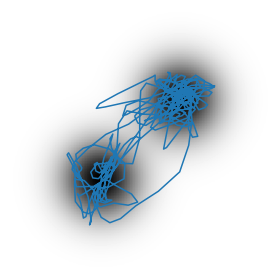

In [470]:
fun = lambda x: bimodal_objective(x, mean1, cov1, mean2, cov2)
XY = np.zeros((100,100))
v = np.linspace(-5,5,100)
for i in range(len(v)):
    for j in range(len(v)):
        XY[i,j] = w1*fun(np.array([v[i],v[j]]))
        
plt.figure()
plt.imshow(np.flip(XY,axis=1),cmap="gist_gray",extent=[-5,5,-5,5])
# plt.scatter(xtraj[0], xtraj[1], s=15, alpha=0.5)
plt.plot(xtraj[0], xtraj[1])
plt.xlim([-5,5])
plt.ylim([-5,5])
# plt.xlabel("x")
# plt.xlabel("y")
plt.axis("off")
plt.tight_layout()
plt.show()

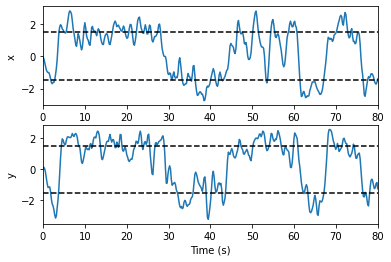

In [471]:
tvec = np.linspace(0,simulation_length*del_t,simulation_length)
plt.figure()
plt.subplot(2,1,1)
plt.plot(tvec,xtraj[0])
plt.plot([tvec[0],tvec[-1]],[mean1[0], mean1[0]],'k--')
plt.plot([tvec[0],tvec[-1]],[mean2[0], mean2[0]],'k--')
plt.xlim([tvec[0],tvec[-1]])
# plt.ylim([-1.5,1.5])
plt.ylabel('x')
plt.subplot(2,1,2)
plt.plot(tvec,xtraj[1])
plt.plot([tvec[0],tvec[-1]],[mean1[1], mean1[1]],'k--')
plt.plot([tvec[0],tvec[-1]],[mean2[1], mean2[1]],'k--')
plt.xlim([tvec[0],tvec[-1]])
# plt.ylim([-1.5,1.5])
plt.ylabel('y')
plt.xlabel('Time (s)')
plt.show()

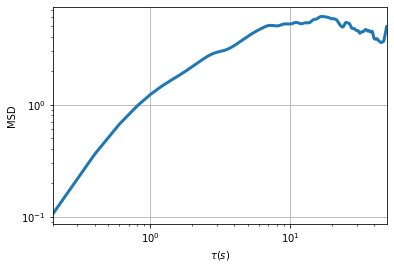

In [473]:
MSDList = []
tauList = list(range(0,int(50.0/del_t)))
for tau in tauList:
    MSDList.append(MSD(xtraj[:2],tau))
    
plt.figure()
plt.plot(del_t*np.array(tauList),MSDList,linewidth=3)
# plt.plot(del_t*np.array(tauList),0.2*(del_t*np.array(tauList)),'r--')
# plt.plot(del_t*np.array(tauList),10*(del_t*np.array(tauList))**2,'r--')
plt.ylabel("MSD")
plt.xlabel(r"$\tau (s)$")
plt.xlim([del_t,del_t*np.max(tauList)])
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.grid(True)
plt.show()

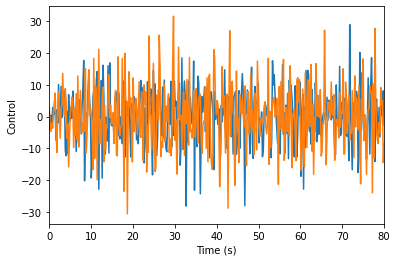

In [474]:
tvec = np.linspace(0,simulation_length*del_t,simulation_length)
plt.figure()
plt.plot(tvec,utraj[0])
plt.plot(tvec,utraj[1])
plt.xlim([tvec[0],tvec[-1]])
plt.ylabel('Control')
plt.xlabel('Time (s)')
plt.show()

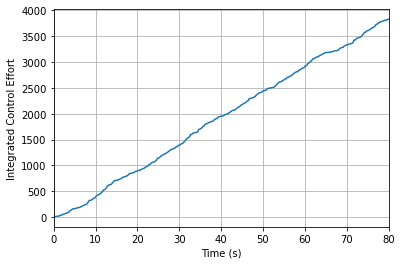

In [475]:
tvec = np.linspace(0,simulation_length*del_t,simulation_length)
plt.figure()
c=0
clist=[]
for i in range(utraj.shape[1]):
    c += np.sqrt(utraj[0,i]**2+utraj[0,i]**2)
    clist.append(c)
plt.plot(tvec,clist)
plt.ylabel('Integrated Control Effort')
plt.xlabel('Time (s)')
plt.xlim([tvec[0],tvec[-1]])
plt.grid(True)
plt.show()

In [450]:
# plt.close('all')